In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
import matplotlib.pyplot as plt
import neptune.new as neptune
import neural_structural_optimization.problems as google_problems
import numpy as np
import pandas as pd
import torch

# first party
import problems
import train
import utils
from matplotlib import colors

# Extra imports
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import xarray
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

# first party
import models
import topo_api
import topo_physics
import utils

# stdlib
import gc
import time

2023-02-25 14:41:08.001198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 14:41:09.620824: I tensorflow/core/common_runtime/local_device.cc:158] LocalDevice using CPU work thread pool: 0x7fd70e579950, num_threads=16
2023-02-25 14:41:09.638180: I tensorflow/core/common_runtime/local_device.cc:158] LocalDevice using CPU work thread pool: 0x7fd70e579950, num_threads=16
2023-02-25 14:41:09.639845: I tensorflow/core/common_runtime/local_device.cc:158] LocalDevice using CPU work thread pool: 0x7fd70e579950, num_threads=16
2023-02-25 14:41:09.640916: I tensorflow/core/common_runtime/local_device.cc:158] LocalDevice using CPU work thread pool: 0x7fd70e579950, num_threads=16
2023-02-25 14:41:09.642320: I tensorflow/core/common_runtime/local_device.cc

In [4]:
problem_name = 'mbb_beam_96x32_0.5'
device = torch.device('cpu')

PROBLEMS_BY_NAME = problems.build_problems_by_name(device=device)
problem = PROBLEMS_BY_NAME.get(problem_name)

In [5]:
def volume_constrained_structural_optimization_function(
    model, initial_compliance, ke, args, device, dtype
):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.

    Notes:
    For the original MBB Beam the best alpha is 5e3
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x

    unscaled_compliance, x_phys, mask = topo_physics.calculate_compliance(
        model, ke, args, device, dtype
    )
    f = 1.0 / initial_compliance * unscaled_compliance

    # Run this problem with no inequality constraints
    ci = None

    ce = pygransoStruct()
    num_materials = len(args['e_materials'])
    total_mass = (
        torch.max(args['material_density_weight'])
        * args['nelx']
        * args['nely']
        * args['combined_frac']
    )
    
    mass_constraint = torch.zeros(num_materials)
    for index, density_weight in enumerate(args['material_density_weight']):
        mass_constraint[index] = density_weight * torch.sum(x_phys[:, index + 1])
        
    c1 = torch.abs((torch.sum(mass_constraint) / total_mass) - 1.0)
    ce.c1 = c1  # noqa

    # # Let's try and clear as much stuff as we can to preserve memory
    del x_phys, mask, ke
    gc.collect()
    torch.cuda.empty_cache()

    return f, ci, ce

In [6]:
# Get the problem args
args = topo_api.specified_task(problem, device=device)

# Let's set up the multi-material problem
args['e_materials'] = torch.tensor([2.0, 1.0], dtype=torch.double)
args['combined_frac'] = torch.tensor([0.4], dtype=torch.double)
args['material_density_weight'] = torch.tensor([1.0, 0.7], dtype=torch.double) 

# Create the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args["young"],
    poisson=args["poisson"],
    device=device,
).double()

In [7]:
seed = 0

np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cnn_model = models.CNNModel(args).to(device=device, dtype=torch.double)

# Calculate initial compliance
initial_compliance, x_phys, _ = topo_physics.calculate_compliance(
    cnn_model, ke, args, device, torch.double
)
initial_compliance = (
    torch.ceil(initial_compliance.to(torch.float64).detach()) + 1.0
)

total_mass = args['volfrac'] * args['nelx'] * args['nely']

/Users/ryandevera/.virtualenvs/ncvx/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
initial_compliance

tensor(1138., dtype=torch.float64)

In [9]:
# Combined function
comb_fn = lambda model: volume_constrained_structural_optimization_function(  # noqa
    cnn_model,
    initial_compliance,
    ke,
    args,
    device=device,
    dtype=torch.double,
)

# Initalize the pygranso options
opts = pygransoStruct()

# Set the device
opts.torch_device = device

# Setup the intitial inputs for the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
).to(device=device, dtype=torch.double)

# Additional pygranso options
opts.limited_mem_size = 20
opts.torch_device = device
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 1500
opts.print_frequency = 1
opts.stat_l2_model = False
opts.viol_eq_tol = 1e-4
opts.opt_tol = 1e-4

mHLF_obj = utils.HaltLog()
halt_log_fn, get_log_fn = mHLF_obj.makeHaltLogFunctions(opts.maxit)

#  Set PyGRANSO's logging function in opts
opts.halt_log_fn = halt_log_fn

# Main algorithm with logging enabled.
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
wall_time = end - start

# GET THE HISTORY OF ITERATES
# Even if an error is thrown, the log generated until the error can be
# obtained by calling get_log_fn()
log = get_log_fn()



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

/Users/ryandevera/.virtualenvs/ncvx/lib/python3.9/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


   2 ║ 0.430467 │  0.49083836855 ║  0.61248873754 ║   -  │ 0.227182 ║ S  │     1 │ 1.000000 ║     1 │ 0.008551   ║ 
   3 ║ 0.313811 │  0.38050367513 ║  0.67511124229 ║   -  │ 0.168647 ║ S  │     1 │ 1.000000 ║     1 │ 0.008707   ║ 
   4 ║ 0.313811 │  0.32608786594 ║  0.95880290785 ║   -  │ 0.025205 ║ S  │     1 │ 1.000000 ║     1 │ 0.019742   ║ 
   5 ║ 0.282430 │  0.22078265095 ║  0.60593143926 ║   -  │ 0.049650 ║ S  │     1 │ 1.000000 ║     1 │ 0.004177   ║ 
   6 ║ 0.282430 │  0.16128762161 ║  0.52765907890 ║   -  │ 0.012261 ║ S  │     1 │ 1.000000 ║     1 │ 0.002110   ║ 
   7 ║ 0.282430 │  0.13217254604 ║  0.43727478638 ║   -  │ 0.008673 ║ S  │     2 │ 2.000000 ║     1 │ 0.001173   ║ 
   8 ║ 0.282430 │  0.10367526227 ║  0.35893542842 ║   -  │ 0.002301 ║ S  │     1 │ 1.000000 ║     1 │ 0.001416   ║ 
   9 ║ 0.282430 │  0.09166325507 ║  0.31248087842 ║   -  │ 0.003409 ║ S  │     1 │ 1.000000 ║     1 │ 0.001205   ║ 
  10 ║ 0.282430 │  0.09004620774 ║  0.28131421164 ║   -  │ 0.010595 ║ S 

In [10]:
# # Final structure
compliance, final_design, _ = topo_physics.calculate_compliance(
    cnn_model, ke, args, device, torch.double
)
final_design = final_design.detach().cpu()

In [11]:
final_design[:, 1].mean() * 1.0 + final_design[:, 2].mean() * 0.8

tensor(0.4264, dtype=torch.float64)

In [12]:
compliance

tensor(168.8337, dtype=torch.float64, grad_fn=<SumBackward0>)

In [13]:
num_materials = len(args['e_materials']) + 1
design = torch.zeros(num_materials, args['nely'], args['nelx'])
for i in range(num_materials):
    design[i, :, :] = final_design[:, i].reshape(args['nelx'], args['nely']).T

In [14]:
final_design = torch.argmax(design, axis=0)

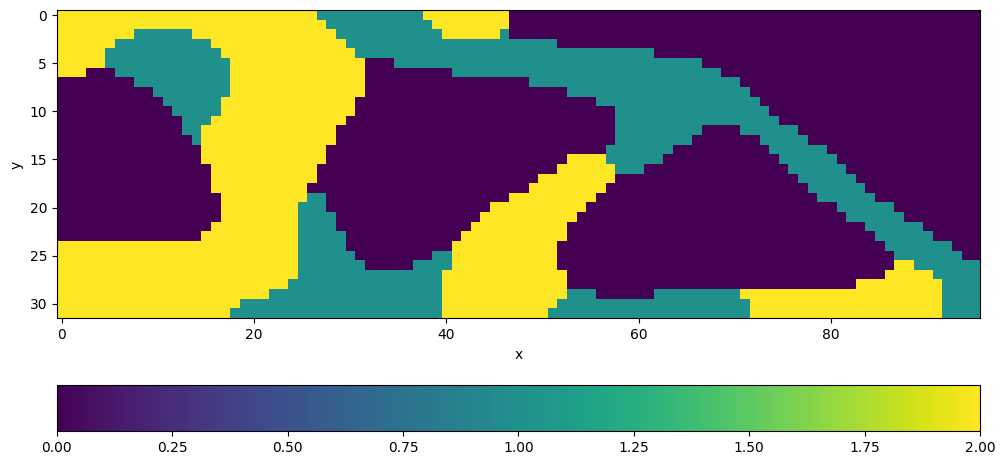

In [15]:
# Setup the figure
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

im = axes.imshow(final_design)
axes.set_xlabel("x")
axes.set_ylabel("y")

fig.tight_layout()
fig.colorbar(im, orientation="horizontal", pad=0.1)

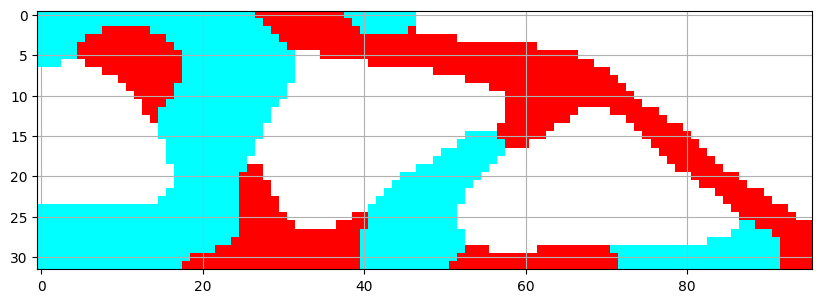

In [16]:
fillColors = ["1.0", "red", "cyan", "black"]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.imshow(
    final_design,
    cmap=colors.ListedColormap(fillColors),
    vmin=0,
    vmax=3
)
ax.grid()